STARTED:      1/30/25

LAST UPDATED: 1/30/25

By Eugene Fong

# TUTORIAL - SCANPY

SOURCE: [https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

### INSTALLS

In [1]:
%pip install pooch
%pip install scikit-image
%pip install igraph

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### IMPORTS

In [2]:
import scanpy as sc
import anndata as ad
import pooch

### PREPROCESSING AND CLUSTERING

In [3]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

In [4]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache('scverse_tutorials'),
    base_url='doi:10.6084/m9.figshare.22716739.v1/',
)
EXAMPLE_DATA.load_registry_from_doi()

In [5]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### QC

In [6]:
# Mitochondrial genes "MT-" for human
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith (('RPS', 'PRL'))

# Hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]')

In [7]:
# CALCULATE - QC Metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars = ['mt', 'ribo', 'hb'],
    inplace = True,
    log1p = True
)

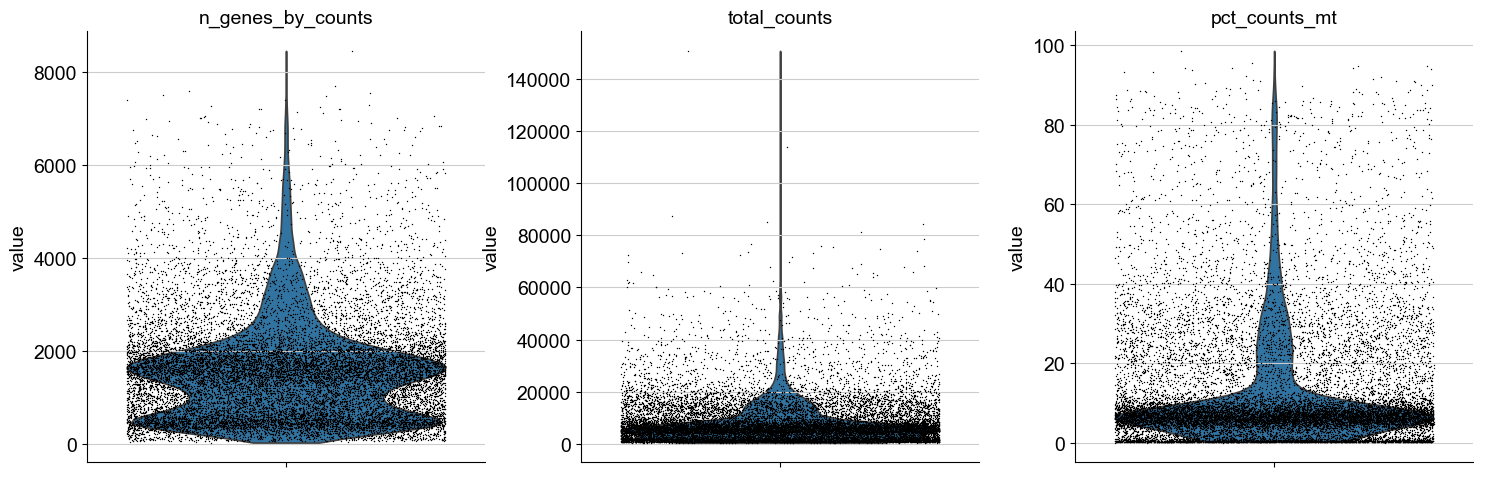

In [8]:
# PLOT - violin plot of QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter = 0.4,
    multi_panel = True,
)

Useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`

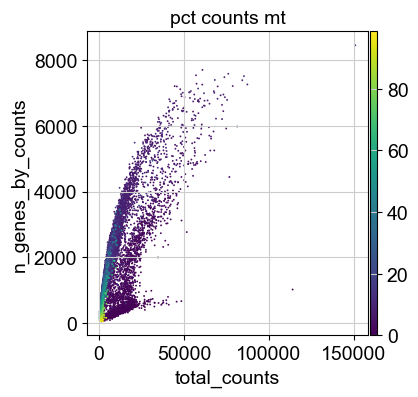

In [9]:
sc.pl.scatter(
    adata,
    'total_counts',
    'n_genes_by_counts',
    color = 'pct_counts_mt'
)

Then remove cells w/too many mito genes using thresholds

In [10]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata, min_cells = 3)

### DOUBLET DETECTION

- Doublets can lead to miscalculations/distortions downstream
- Scanpy uses Scrublet which uses NN to predict cell doublets
- `scanpy.pp.scrublet()` adds `doublet_score` and `predicted_doublet` to `.obs`

One can now either filter directly on predicted_doublet or use the doublet_score later during clustering to filter clusters with high doublet scores.

In [11]:
# Run scrublet for doublet detection
sc.pp.scrublet(
    adata,
    batch_key = 'sample'
)

### NORMALIZATION

Common approach is count depth scaling w/log plus one (log1p) transformation

- Count depth scaling normalizes the data to a "size factor" (such as median)
- Size factor controlled via `target_sum` in `pp.normalize_total`

In [12]:
# Saving count data
adata.layers['counters'] = adata.X.copy()

In [13]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

### FEATURE SELECTION

Reduce dimensionality and keep only the most informative genes

- `pp.highly_variable_genes` annotates highly variable genes by reproducing implementations of Seurat, Cell Ranger and Seurat based on your `flavor`

In [14]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 2000,
    batch_key = 'sample'
)

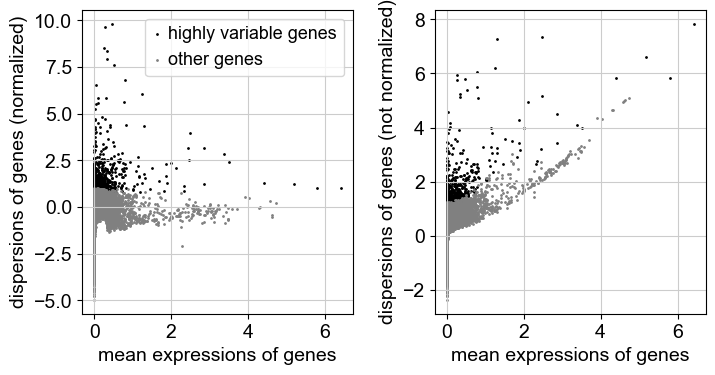

In [15]:
sc.pl.highly_variable_genes(adata)

### DIMENSIONALITY REDUCTION

Reduces the dimensions by running PCA

- reveals the main axes of variation
- denoises the data

In [16]:
sc.tl.pca(adata)

Inspect the contribution of single PCs to the total variance.

- gives us info about how many PCs we should consider in order to compute the neighborhood relations of cells used in the clustering function (ie. `leiden()` or `tsne()`)
- no major downsides to overestimating the # of PCs

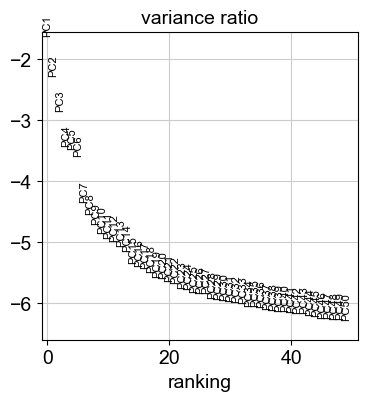

In [17]:
sc.pl.pca_variance_ratio(
    adata,
    n_pcs = 50, 
    log = True
)

You can also plot the PCs to see if any potentially undesired features (ie. batch, QC metrics) driving significant variation

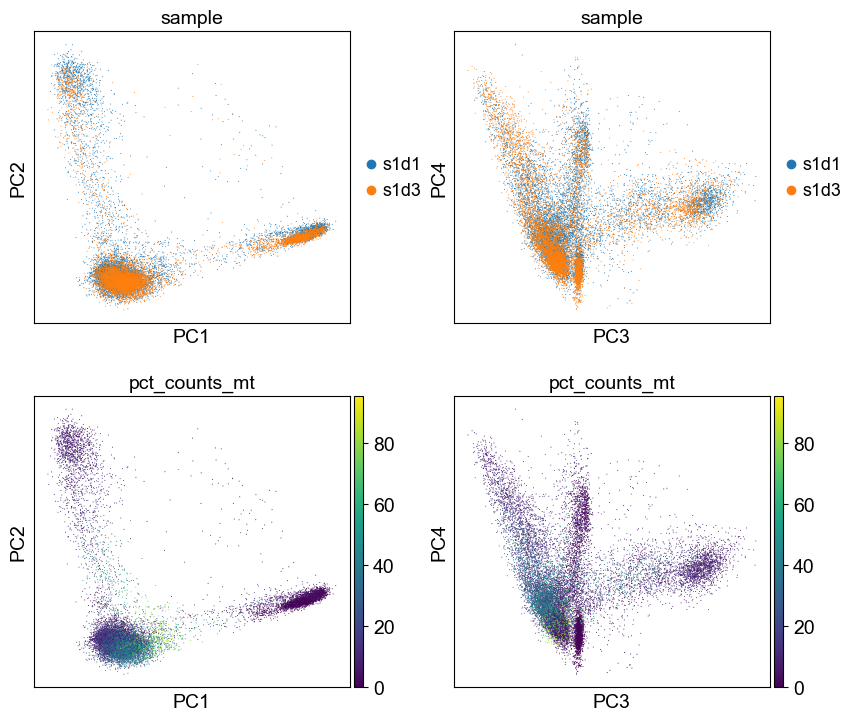

In [18]:
sc.pl.pca(
    adata,
    color = ["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions = [(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols = 2,
    size = 2,
)

### NN graph construction and viz

PCA representation of the data matrix

In [19]:
sc.pp.neighbors(adata)

Can be embedded in 2Ds for viz w/UMAP

In [20]:
sc.tl.umap(adata)

Viz the UMAP

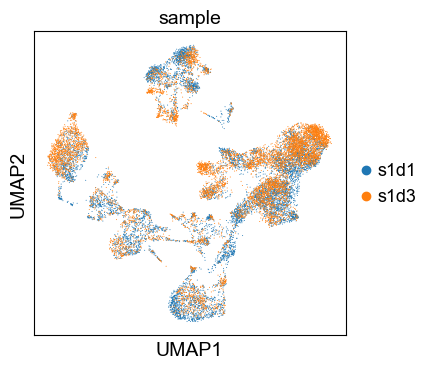

In [21]:
sc.pl.umap(
    adata,
    color = 'sample',
    size = 2 # smaller pts prevent overlap
)

2 diff samples in the data, minor batch effect, can continue w/clustering + annotation

BUT

If you see batch effects in your UMAP, it can be beneficial to integrate across samples and do batch correction/integration.

Recs: `scanorama` and `scvi-tools` for batch integration

### CLUSTERING

Like w/Seurat and other frameworks, they rec Leiden graph-clustering (community detection based on optimizing modularity).

NOTE: Leiden clustering directly clusters the neighborhood graph of cells which we already computed in the previous section

In [22]:
# Using igraph implementation and a fixed # of iterations can be much faster on large datasets
sc.tl.leiden(
    adata,
    flavor = 'igraph',
    n_iterations = 2
)

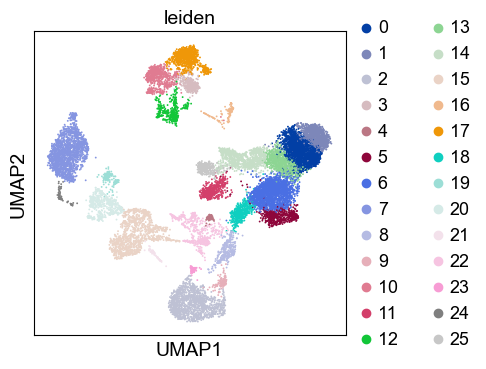

In [23]:
sc.pl.umap(
    adata,
    color = ['leiden']
)

### RE-ASSESS QC + CELL FILTERING

By visualizing diff QC metrics using UMAP

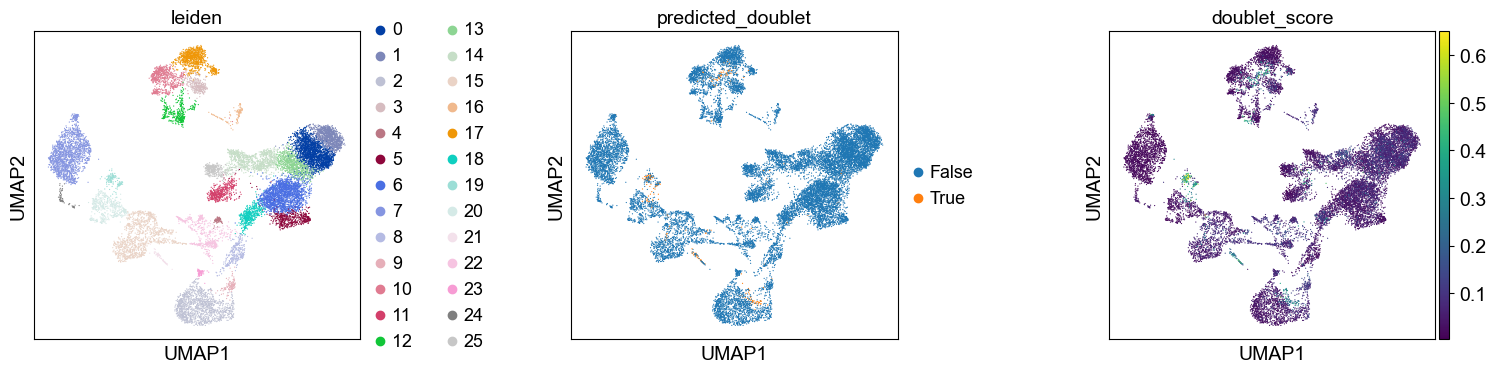

In [24]:
sc.pl.umap(
    adata,
    color = ['leiden', 'predicted_doublet', 'doublet_score'],
    wspace = 0.5, # increase horizontal space betw panels
    size = 3
)

### MANUAL CELL-TYPE ANNOTATION

Cell type annotation is laborous and repetitive, often needs multi rounds of subclustering and re-annotation. Typically done using genes that are exclusively expressed by a given cell type to distinguish from other groups of cells in our data. 

Curated various marker genes at:

- [CellMarker](http://bio-bigdata.hrbmu.edu.cn/CellMarker/)
- [TF-Marker](http://bio.liclab.net/TF-Marker/)
- [PanglaoDB](https://panglaodb.se/)

[cellxgene gene expression tool](https://cellxgene.cziscience.com/gene-expression) can also be useful to see which cell types a gene has been expressed in across many existing DBs

Let's gen a set of clustering solutions which we can then use to annotate our cell types. Using the Leiden clustering algo it'll extract cell communities from our NN graph

In [25]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata,
        key_added = f'leiden_res_{res:4.2f}',
        resolution = res,
        flavor = 'igraph'
    )

NOTE: the # of cluster we define along with the `resolution` is arbitrary. So the # of clusters is really bound to the stable and biologically meaningful groups we can really distinguish, done by experts

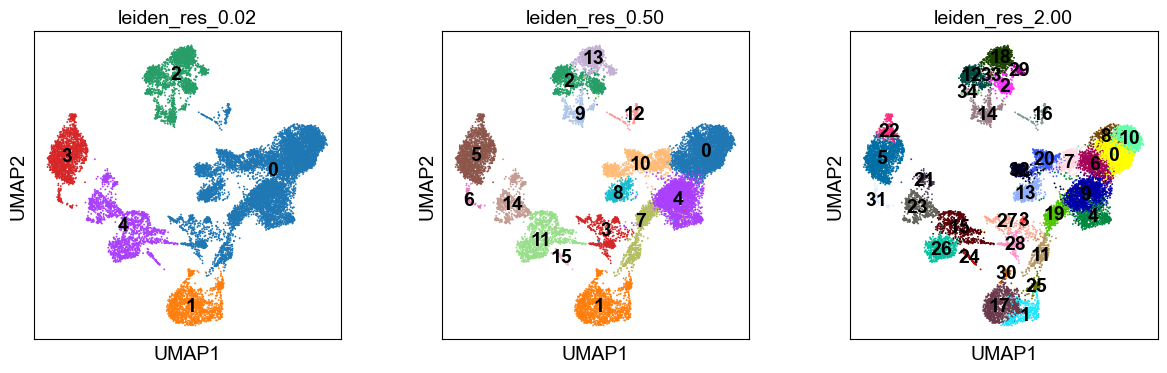

In [26]:
sc.pl.umap(
    adata,
    color = ['leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00'],
    legend_loc = 'on data'
)

NOTE:

- highest res is over-clustered
- lowest res is likely grouping cells which should be distinct

### MARKER GENE SET

Let's define a set of marker genes for the main cell types that we expect to see. Adapted from [Single Cell Best Practices annotation chapter](https://www.sc-best-practices.org/cellular_structure/annotation.html)

In [27]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

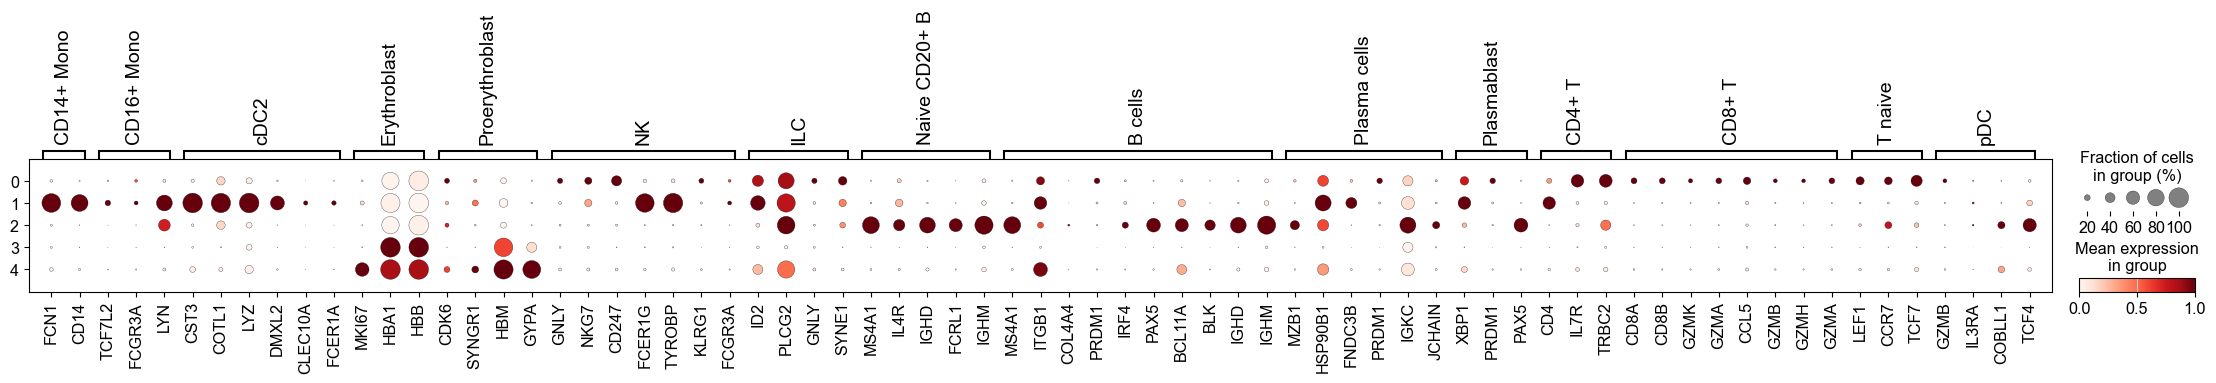

In [28]:
sc.pl.dotplot(
    adata,
    marker_genes,
    groupby = 'leiden_res_0.02',
    standard_scale = 'var'
)

There are fairly clear patterns of expression for our markers show here, which we can use to label our coarsest clustering with broad lineages.

In [29]:
adata.obs['cell_type_lvl1'] = adata.obs['leiden_res_0.02'].map(
    {
        '0': 'Lymphoctyes',
        '1': 'Monocytes',
        '2': 'Erythroid',
        '3': 'B Cells',
    }
)

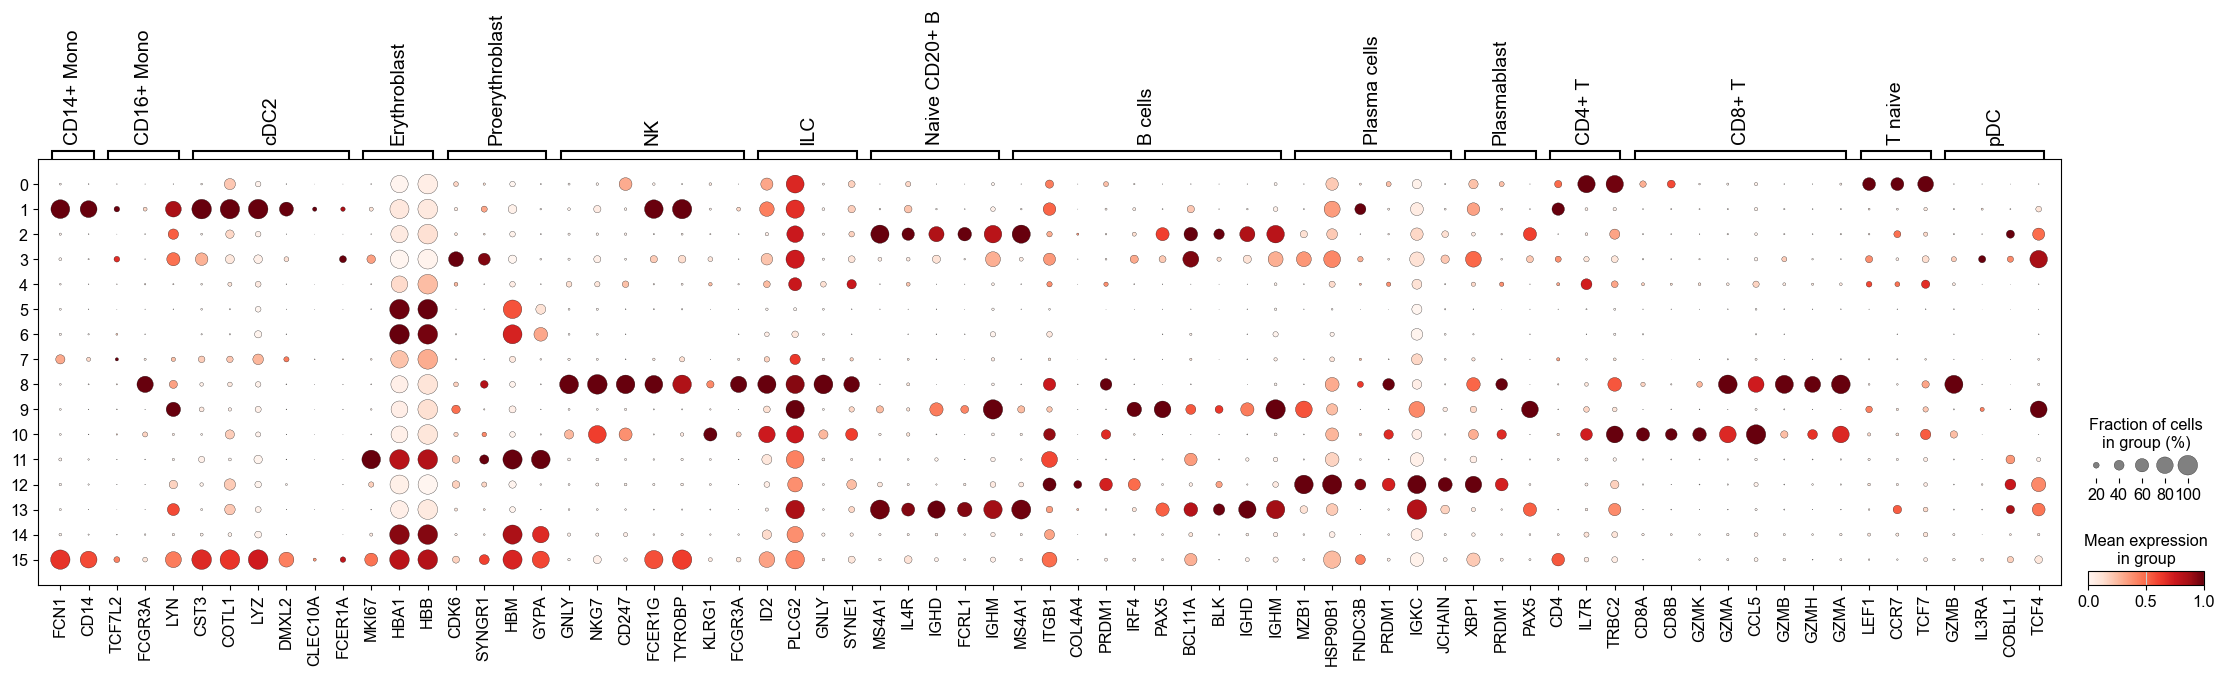

In [30]:
sc.pl.dotplot(
    adata,
    marker_genes,
    groupby = 'leiden_res_0.50',
    standard_scale = 'var'
)

This seems like a resolution that suitable to distinguish most of the different cell types in our data. As such, let’s try to annotate those by manually using the dotplot above, together with the UMAP of our clusters. Ideally, one would also look specifically into each cluster, and attempt to subcluster those if required.

### DIFFERENTIALLY-EXPRESSED (DE) GENES AS MARKERS

Can also calc marker genes/cluster and then look up whether we can link those marker genes to known biology (ie. cell types and/or states). Can be done using simple stat tests (ie. Wilcoxon and t-test) for each cluster VS the rest.

In [31]:
# Obtain cluster-specific DE genes
sc.tl.rank_genes_groups(
    adata,
    groupby = 'leiden_res_0.50',
    method = 'wilcoxon'
)

Viz the top 4 DE genes on a dotplot

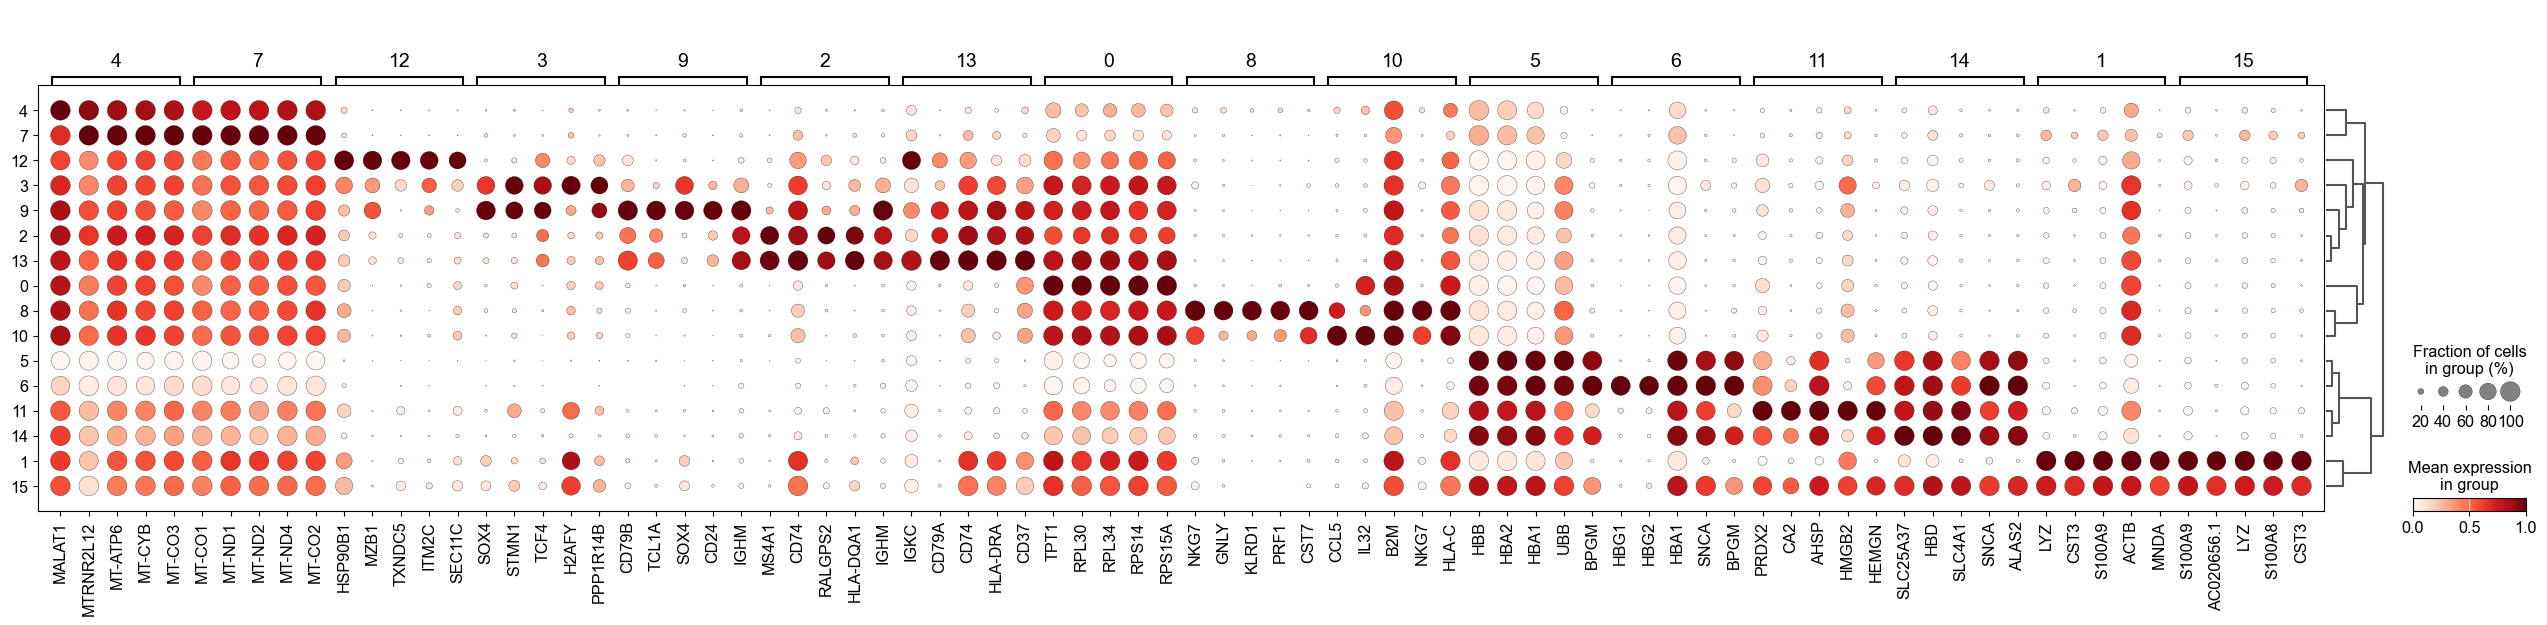

In [32]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby = 'leiden_res_0.50',
    standard_scale = 'var', 
    n_genes = 5
)

Can then use these genes to figure out what cell types we're looking at. For ex: Cluster 7 is expressing NKG7 and GNLY, suggesting they are NK cells.

To create your own plots, or use a more automated approach, the DE genes can be extracted in a convenient format w/`scanpy.get.rank_genes_groups_df()`

In [33]:
sc.get.rank_genes_groups_df(
    adata,
    group = '7'
).head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,MT-CO1,45.590153,3.257149,0.0,0.0
1,MT-ND1,45.286713,3.366034,0.0,0.0
2,MT-ND2,44.956135,3.361203,0.0,0.0
3,MT-ND4,44.839104,3.122482,0.0,0.0
4,MT-CO2,44.697105,3.215490,0.0,0.0


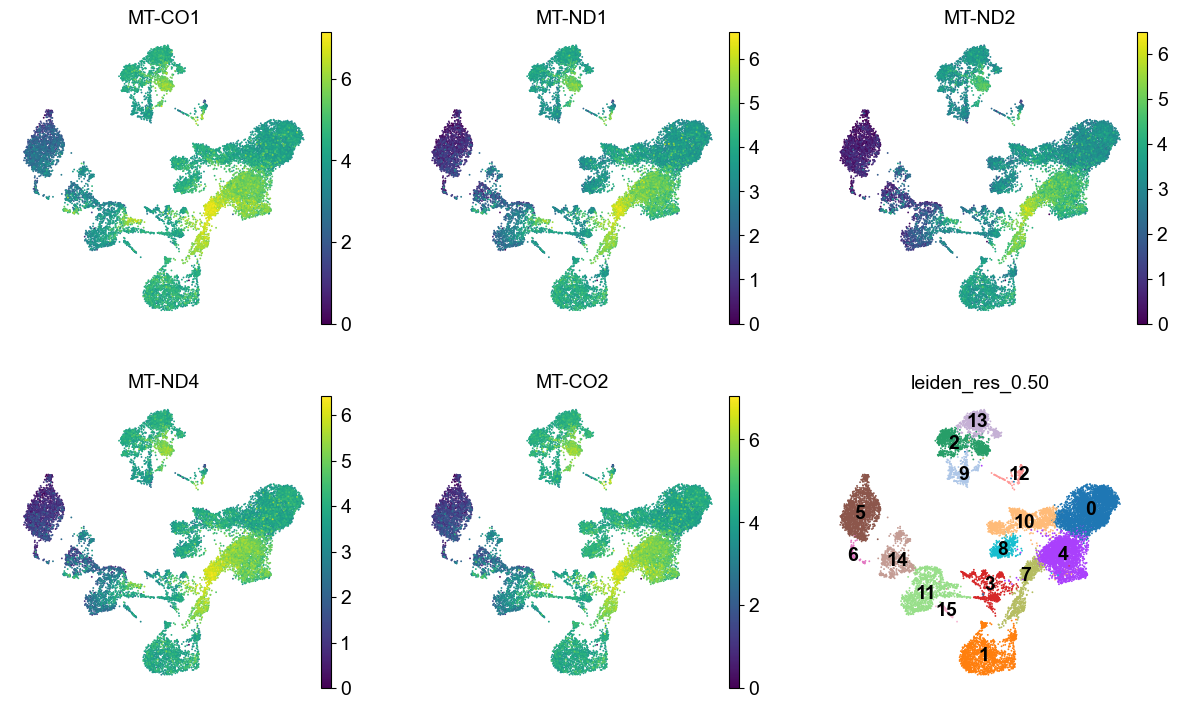

In [34]:
dc_cluster_genes = sc.get.rank_genes_groups_df(
    adata,
    group = '7'
).head(5)['names']

sc.pl.umap(
    adata,
    color = [*dc_cluster_genes, 'leiden_res_0.50'],
    legend_loc = 'on data',
    frameon = False,
    ncols = 3,
)

### NOTE: these dotplots and UMAPs look very diff from the Tutorial, oddly high expression of 'MT'

P-vals found here are extremely low de to the stat test being performed considering each cell as an indep sample. For a more conservative appraoch you may way to consider "pseudo-bulking" your data by sample:

```
sc.get.aggregate(adata, by = ['sample', 'cell_type'], func = 'sum', layer = 'counts')
``` 

and using a more powerful DE tool, like `pydeseq2`

In [ ]:
sc.get.aggregate(
    adata, 
    by = ['sample', 'cell_type'], 
    func = 'sum', 
    layer = 'counts'
)

KeyError: 'counts'